# Feature Mathching

Submitted by: Ephi Frankel




In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.misc import imread
from scipy.signal import correlate2d 
from scipy.ndimage import gaussian_filter
def gaussian(n,sigma):
    # generates a Gaussian kernel of size (2n+1)*(2n+1)
    x = np.arange(-n,n+1)
    y = np.arange(-n,n+1)
    xx, yy = np.meshgrid(x,y)
    z = np.exp(-(xx**2+yy**2)/(2*sigma**2))
    z = z/z.sum()
    return z
def filter2D(img_in, kernel):   
    # check kernel dimensions
    ker_h, ker_w = kernel.shape
    if ker_h != ker_w:
        raise ValueError('expected square-size kernel')
    if ker_h%2==0:
        raise ValueError('expected odd-size kernel')   
    n = int((ker_h-1)/2)
    w = (img_in.shape[0] + 2*n)
    
    h = (img_in.shape[1] + 2*n)
    img_tmp = np.zeros((w,h))
    img_tmp[n:-n,n:-n] = img_in
    x_end = img_in.shape[0]+1
    y_end = img_in.shape[1]+1
    img_out = np.zeros((img_in.shape[0],img_in.shape[1]))
    for x in range(n,x_end):
        for y in range(n,y_end):
            img_out[x-n,y-n] = (img_tmp[x-n:x-n+ker_h,y-n:y-n+ker_w]*kernel).sum()
    return img_out
def show(imgs,imgNames):
    plt.figure(figsize=(13,7))
    pltNumber = 1
    for i,img_t in enumerate(imgs):
        plt.subplot(1,4,pltNumber)
        plt.imshow(img_t,cmap='gray')
        plt.title('{}'.format(imgNames[i]))
        pltNumber = pltNumber + 1
    plt.show()
def harris_corner_detector(img,gaussian_kernel,percentage,debug = False,usePercentile = False,margin = -1):
    SxWithSmooth = np.array([[1,0,-1],
              [2,0,-2],
              [1,0,-1]])
    SyWithSmooth = SxWithSmooth.T
    Gx = filter2D(img, SxWithSmooth)
    Gy = filter2D(img, SyWithSmooth)
    if(debug):
        imgs = [Gx,Gy]
        imgNames = ['Gx','Gy']  
        show(imgs,imgNames)
    GxPow2 = Gx**2
    GyPow2 = Gy**2
    GxGy = Gx*Gy
    if(debug):
        imgs = [GxPow2,GyPow2,GxGy]
        imgNames = ['Gx^2','Gy^2','GxGy'] 
        show(imgs,imgNames)
    m11 = filter2D(GxPow2, gaussian_kernel)
    m22 = filter2D(GyPow2, gaussian_kernel)
    m12 = filter2D(GxGy, gaussian_kernel)
    if(debug):
        imgs = [m11,m22,m12]
        imgNames = ['Gx^2 with gaus fillter','Gy^2 with gaus fillter','GxGy with gaus fillter'] 
        show(imgs,imgNames)
    det_M = m11*m22-m12*m12
    tr_M = m11+m22
    alpha = 0.06
    R = det_M - alpha*(tr_M**2)
    if(debug):
        plt.figure(figsize=(13,7))
        plt.imshow(R,cmap='jet')
        plt.colorbar()
        plt.title('R')
        plt.show()
    if(usePercentile):
        thrshold = np.percentile(R,percentage)
    else:
        maximum = R.max()
        thrshold = percentage * maximum
    thrsholded_R = R > thrshold
    if(debug):
        plt.figure(figsize=(13,7))
        plt.imshow(thrsholded_R,cmap='gray')
        plt.colorbar()
        plt.title('thrsholded_R')
        plt.show()
    R_N = np.zeros_like(R)  # the North neighbor
    R_N[1:,:] = R[:-1,:]
    R_S = np.zeros_like(R)  # the South neighbor
    R_S[1:,:] = R[:-1,:]
    R_W = np.zeros_like(R)  # the West neighbor
    R_W[:,1:] = R[:,:-1]
    R_E = np.zeros_like(R)  # the East neighbor
    R_E[:,:-1] = R[:,1:]
    R_NE = np.zeros_like(R)  # the North East neighbor
    R_NE[1:,:-1] = R[:-1,1:]
    R_NW = np.zeros_like(R)  # the North West neighbor
    R_NW[1:,1:] = R[:-1,:-1]
    R_SW = np.zeros_like(R)  # the South West neighbor
    R_SW[:-1,1:] = R[1:,:-1]
    R_SE = np.zeros_like(R)  # the South East neighbor
    R_SE[:-1,:-1] = R[1:,1:]
    msk = np.zeros_like(R)  # Init msk matrix
    msk =  (R_S<R) * (R_E<R) * (R_NW<R) * (R_SE<R) * (R_N<R) * (R_S<R) * (R_NE<R) * (R_SW<R)

    R_NMS = np.zeros_like(R)
    R_NMS[msk] = thrsholded_R[msk]
    if(margin > -1):
        R_NMS[0:margin,:] = False
        R_NMS[-margin:,:] = False
        R_NMS[:,0:margin] = False
        R_NMS[:,-margin:] = False
    if(debug):
        plt.imshow(R_NMS,cmap='gray')
        plt.colorbar()
        plt.title('R_NMS')
    return np.nonzero(R_NMS)



The goal of this assignment is to create a local feature matching algorithm. 

First we detect interest points (features) in each image (using your Harris corners implementation). 

Then we use some descriptor to describe each of the detected features. 

Finally, the matching process is as follows: It takes the descriptor of one feature in first set and is matched with all other features in second set using some distance function. The closest one (minimum distance) is returned.


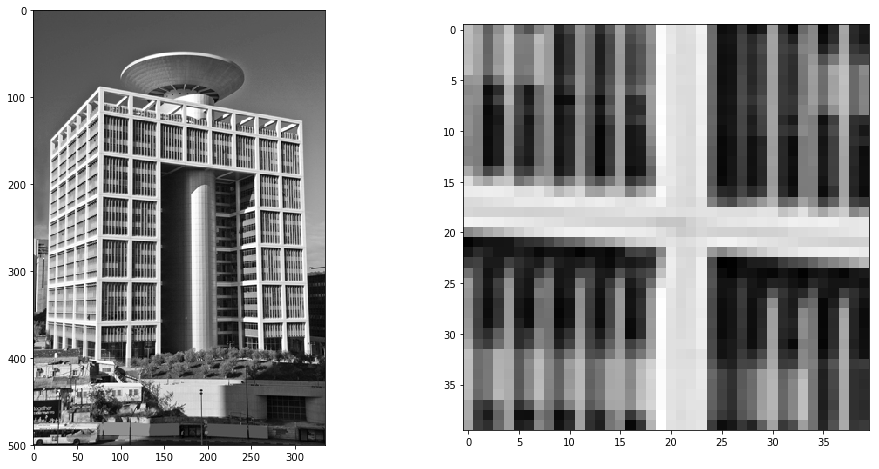

In [2]:
# load some test images

source_img = imread('kiria.jpg','L')
query_img = source_img[195:235,90:130]


plt.figure(figsize=(16,8))
ax1 = plt.subplot(1,2,1)
ax1.imshow(source_img, cmap='gray',interpolation='nearest')
ax2 = plt.subplot(1,2,2)
ax2.imshow(query_img, cmap='gray',interpolation='nearest')
plt.show()

### 1. Feature Detector

The feature detector uses Harris score with a threshold as a parameter. It detects features with a score above the threshold and uses maxima-supression. 

Note, the detector should discard points that are too close to the boundary of the image (with N being the margin parameter).

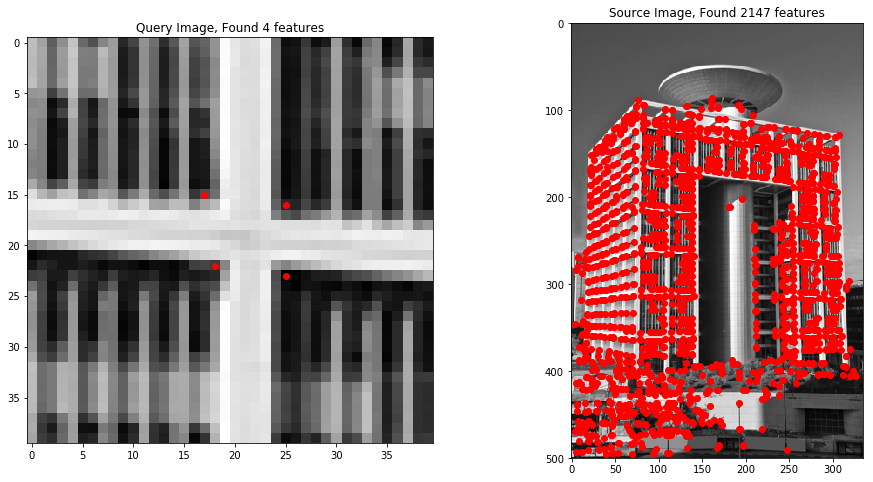

In [3]:
# detect features in the source-image and in the query-image. plot the results
# how many features detected in each image? (print the result)


# your code here..
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
gaussian_kernel = gaussian(3,1)
query_img_smoothed = filter2D(query_img,gaussian_kernel)
y,x = harris_corner_detector(query_img,gaussian_kernel,98.5,False,True,4)
plt.imshow(query_img, cmap='gray',interpolation='nearest')
plt.title('Query Image, Found {} features'.format(y.shape[0]))
plt.plot(x,y,'or')



plt.subplot(1,2,2)
gaussian_kernel = gaussian(3,1.5)   
source_img_smoothed = filter2D(source_img,gaussian_kernel)
y2,x2 = harris_corner_detector(source_img,gaussian_kernel,80,False,True,4)
plt.imshow(source_img, cmap='gray',interpolation='nearest')
plt.title('Source Image, Found {} features'.format(y2.shape[0]))
plt.plot(x2,y2,'or')
plt.show()


### 2. Feature Descriptor

We will implement 3 types of descriptors:

- `desc_simple`: is a simple descriptor, a collection of all pixels values, in a square (9x9) patch around the feature.

- `desc_hist`: is a gradients histogram descriptor. first, collect all the gradients in a square (9x9) patch around the feature. then, use `plt.hist` to calculate their oreintations hisogram ($[0-2\pi]$ divided into 6 bins). Use the gradients magnitudes as weights in the histogram.

- `desc_sift` (Bonus): SIFT-like descriptor. first, divide the 9x9 square patch around the feature into 9 sub-patches, each of a 3x3 size. next, in each sub-patch calculate the gradients histogram (as in desc2). finally, combine all 9 hisograms to a single 54 long descriptor (9 sub-patches x 6 bins). 


Each of the functions, returns the descriptors in a $n\times d$ matrix, where $n$ is the number of the feature and $d$ the dimension of the descriptor (each row describes one feature).


In [4]:
def desc_simple (desc_img, x_desc,y_desc):
    desc = np.zeros((len(x_desc), 9))  
    # your code here..
    for t in range(x_desc.shape[0]):
        x_t = x_desc[t]
        y_t = y_desc[t]
        patch = desc_img[y_t-1:y_t+2,x_t-1:x_t+2].flatten()
        desc[t] = patch 
    return desc

In [5]:
def desc_hist (desc_img,x_desc,y_desc):
    desc = np.zeros((len(x_desc), 6))  
    # your code here..
    SxWithSmooth = np.array([[1,0,-1],
              [2,0,-2],
              [1,0,-1]])
    SyWithSmooth = SxWithSmooth.T
    Gx = filter2D(desc_img, SxWithSmooth)
    Gy = filter2D(desc_img, SyWithSmooth)
    G = np.sqrt(Gx**2 + Gx**2)
    theta = np.arctan2(Gy,Gx) + np.pi
    for t in range(x_desc.shape[0]):
        x_t = x_desc[t]
        y_t = y_desc[t]
        patchTheta = theta[y_t-1:y_t+2,x_t-1:x_t+2].flatten()
        patchG = G[y_t-1:y_t+2,x_t-1:x_t+2].flatten()
        hist = np.histogram(patchTheta,6,(0,2*np.pi),weights=patchG)[0]
        desc[t] = hist
    return desc

In [6]:
def desc_sift (desc_img, x_desc,y_desc):
    desc = np.zeros((len(x_desc), 54))  
    # your code here..
    SxWithSmooth = np.array([[1,0,-1],
              [2,0,-2],
              [1,0,-1]])
    SyWithSmooth = SxWithSmooth.T
    Gx = filter2D(desc_img, SxWithSmooth)
    Gy = filter2D(desc_img, SyWithSmooth)
    G = np.sqrt(Gx**2 + Gx**2)
    theta = np.arctan2(Gy,Gx) + np.pi
    for t in range(x_desc.shape[0]):
        x_t = x_desc[t]
        y_t = y_desc[t]
        patchTheta = theta[y_t-4:y_t+5,x_t-4:x_t+5]
        patchG = G[y_t-4:y_t+5,x_t-4:x_t+5]
        readyForHistTheta = patchTheta.reshape(3,3,3,3).transpose(0,2,1,3).reshape(9,9)
        readyForHistG = patchG.reshape(3,3,3,3).transpose(0,2,1,3).reshape(9,9)
        hist = np.array([])
        for i in range(readyForHistTheta.shape[0]):
            currentHistTheta =  readyForHistTheta[i]
            currentHistG = readyForHistG[i]
            currentHist = np.histogram(currentHistTheta,6, weights=currentHistG,range=(0,2*np.pi))[0]
            hist = np.append(hist,currentHist)
        desc[t] = hist
    return desc

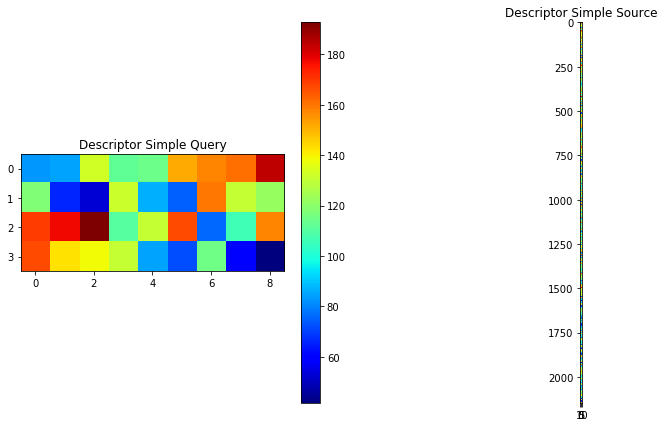

In [7]:
# calculate the descriptors  of each feature found in 'image' and 'query'
descSimpleQuery = desc_simple(query_img_smoothed,x,y)
descSimpleSource = desc_simple(source_img_smoothed,x2,y2)
# plot the resulted descriptor matrices (use plt.imshow() with jet colormap)
plt.figure(figsize=(13,7))
plt.subplot(1,2,1)
plt.title('Descriptor Simple Query')
plt.imshow(descSimpleQuery,cmap='jet')
plt.colorbar()
plt.subplot(1,2,2)
plt.title('Descriptor Simple Source')
plt.imshow(descSimpleSource,cmap='jet')
plt.show()

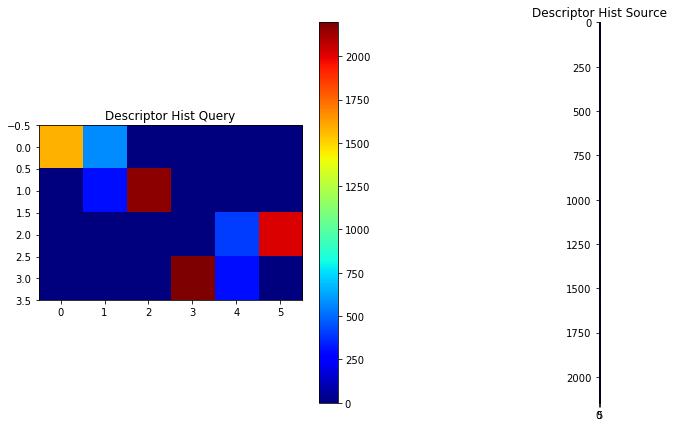

In [8]:
# plot the resulted descriptor matrices (use plt.imshow() with jet colormap)
plt.figure(figsize=(13,7))
plt.subplot(1,2,1)
#calculate hist query
descHistQuery = desc_hist(query_img_smoothed,x,y)
#showing..
plt.title("Descriptor Hist Query")
plt.imshow(descHistQuery,cmap='jet')
plt.colorbar()
plt.subplot(1,2,2)
#calculate hist source
descHistSource = desc_hist(source_img_smoothed,x2,y2)
#showing..
plt.title("Descriptor Hist Source")
plt.imshow(descHistSource,cmap='jet')
plt.show()

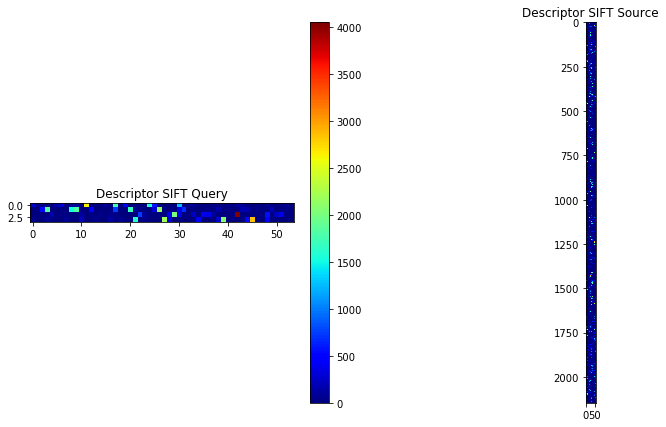

In [9]:
# plot the resulted descriptor matrices (use plt.imshow() with jet colormap)
plt.figure(figsize=(13,7))
plt.subplot(1,2,1)
#calculate hist query
descSIFTQuery = desc_sift(query_img_smoothed,x,y)
#showing..
plt.title("Descriptor SIFT Query")
plt.imshow(descSIFTQuery,cmap='jet')
plt.colorbar()
plt.subplot(1,2,2)
#calculate hist source
descSIFTSource = desc_sift(source_img_smoothed,x2,y2)
#showing..
plt.title("Descriptor SIFT Source")
plt.imshow(descSIFTSource,cmap='jet')
plt.show()

### 3. Matching the features

First, calculate the (Euclidian) distance between each feature in the source-image and each feature in query-image:

$$f(D_1,D_2)=\frac{1}{N}\sum_{i=1}^N{\left({D_1(i)-D_2(i)}\right) }^2$$

Next, for each feature $i$ in img1 ($i=1,...,n_1$)
- find its most similar feature in img2 
- return the ID of the most similar feature $\text{ID}(i)\in\{1,...,n_2\}$ and their distance.


hint: np.max and np.argmax might come handy..

Plot the two images side-by-side. Add the feature points to each image (blue points). Mark the matching features (red points) - if their distance was smaller than a certain threshold.

Play with the parameters until you get a good result.
    

In [10]:
def calc_distances (desc1, desc2):
    
    n1 = desc1.shape[0]
    n2 = desc2.shape[0]
    paired_dist = np.zeros((n1,n2))
    # your code here..
    for i in range(n1):
        for j in range(n2):
            #result = 0
            #for indx in range(desc1[i].shape[0]):
                #result = result + (desc1[i][indx] - desc2[j][indx])**2
            #result = result / desc1[i].shape[0]
            result = np.mean((desc1[i] - desc2[j])**2)
            paired_dist[i][j] = result
    ID = np.argmin(paired_dist,axis=1)
    dst = np.min(paired_dist,axis=1)
    #print(dst.shape,n1)
    return ID, dst # ID and dst are vectors of size n1
def get_cmap(n, name='hsv'):
    #'''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    #RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)
def display_not_detailed_result(desc1,desc2,th,name):
    # Descriptor Matching
    ID,dst =calc_distances(desc1,desc2)
    dstTh = np.percentile(dst,th)
    msk = dst <= dstTh
    #showing..
    print('Feature Matching by {} Descriptor'.format(name))
    plt.figure(figsize=(16,8))
    plt.subplot(1,2,1)
    plt.imshow(query_img, cmap='gray',interpolation='nearest')
    plt.title('Query Image, Found {} features'.format(y.shape[0]))
    plt.plot(x,y,'or')

    x2_found = x2[msk]
    y2_found = y2[msk]
    plt.subplot(1,2,2)
    plt.imshow(source_img, cmap='gray',interpolation='nearest')
    plt.title('Source Image, Found {} features, matched {} features'.format(y2.shape[0],len(x2_found)))
    plt.plot(x2,y2,'ob')
    plt.plot(x2_found,y2_found,'or')
    plt.show()
def display_result(desc1,desc2,th,name):
    # Descriptor Matching
    ID,dst =calc_distances(desc1,desc2)
    dstTh = np.percentile(dst,th)
    msk = dst <= dstTh
 
    
    #Showing...
    print('Feature Matching by {} Descriptor'.format(name))
    plt.figure(figsize=(20,12))
    plt.subplot(1,2,1)
    plt.imshow(query_img, cmap='gray',interpolation='nearest')
    plt.title('Query Image, Found {} features'.format(y.shape[0]))
    clrMap = get_cmap(x.shape[0],'jet')
    legend = np.array([])
    legendRead = np.array([])
    for i in range(x.shape[0]):
        data = plt.scatter(x[i],y[i],c=clrMap(i))
        legend = np.append(legend,data)
        legendRead = np.append(legendRead,np.array(['Feature {}'.format(i+1)]))
    plt.legend(legend,legendRead,loc='lower left', bbox_to_anchor=(1, 0.06), ncol=1)

    plt.subplot(1,2,2)
    plt.imshow(source_img, cmap='gray',interpolation='nearest')
   
    matchCount = 0
    appendData = True
    toScatter = []
    for i in range(x2.shape[0]):
        if(msk[i] == False):
            data = plt.scatter(x2[i],y2[i],c='black')
            if(appendData):
                legend = np.append(legend,data)
                legendRead = np.append(legendRead,np.array(['Unmatched']))
                appendData = False
        else:
            clr = clrMap(ID[i])
            matchCount = matchCount + 1
            toScatter.append([x2[i],y2[i],clr])
    for [x2s,y2s,clr] in toScatter:
            plt.scatter(x2s,y2s,c=clr)
    plt.title('Source Image, Found {} features, was able to match {} features by thrshold of {}'.format(y2.shape[0],matchCount,dstTh))
    plt.legend(legend,legendRead,loc='lower left', bbox_to_anchor=(1, 0.09), ncol=1)        
    plt.show()

Feature Matching by Simple Descriptor


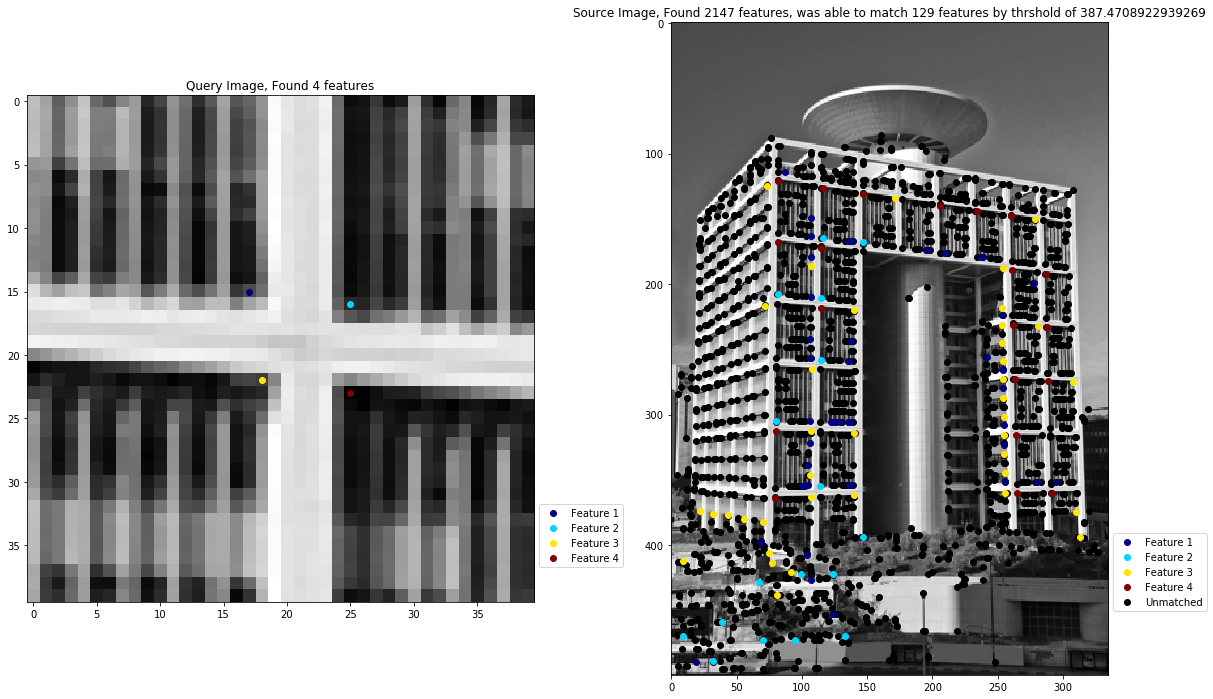

In [29]:
#remove comment to display with match to each feature
display_result(descSimpleSource,descSimpleQuery,6,'Simple')
#display_not_detailed_result(descSimpleSource,descSimpleQuery,6,'Simple')

Feature Matching by Histogram Descriptor


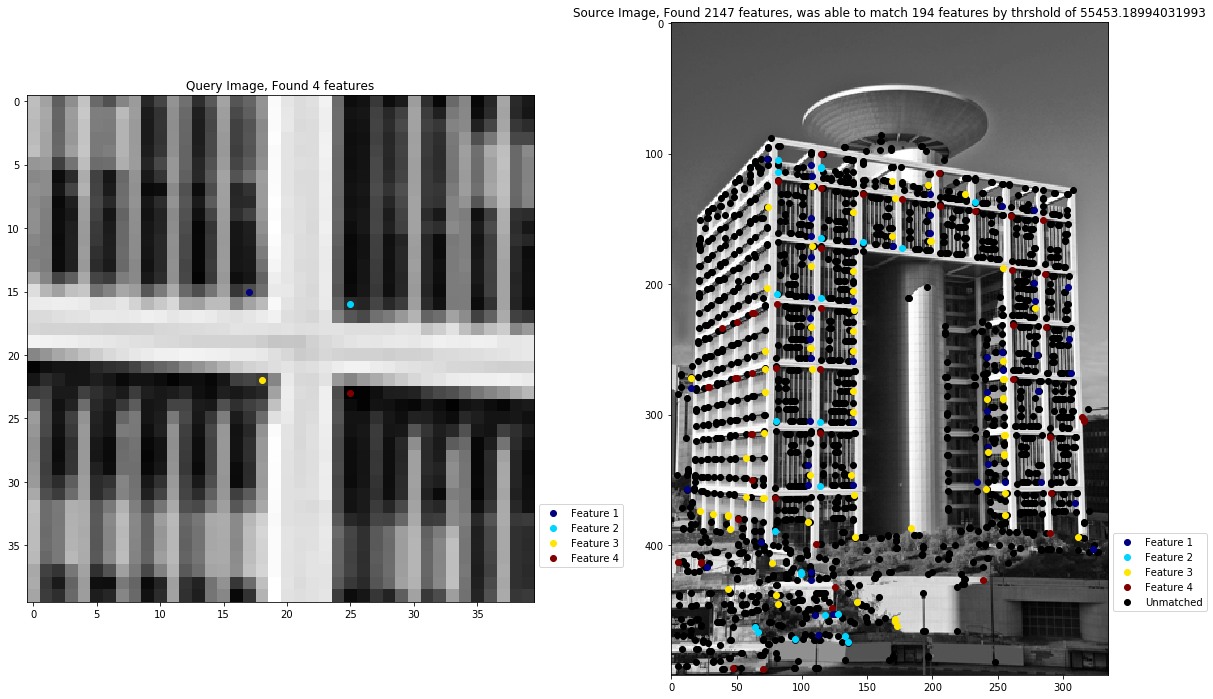

In [30]:
display_result(descHistSource,descHistQuery,9,'Histogram')
#remove comment to display without match to each feature 
#display_not_detailed_result(descHistSource,descHistQuery,10,'Histogram')

Feature Matching by SIFT Descriptor


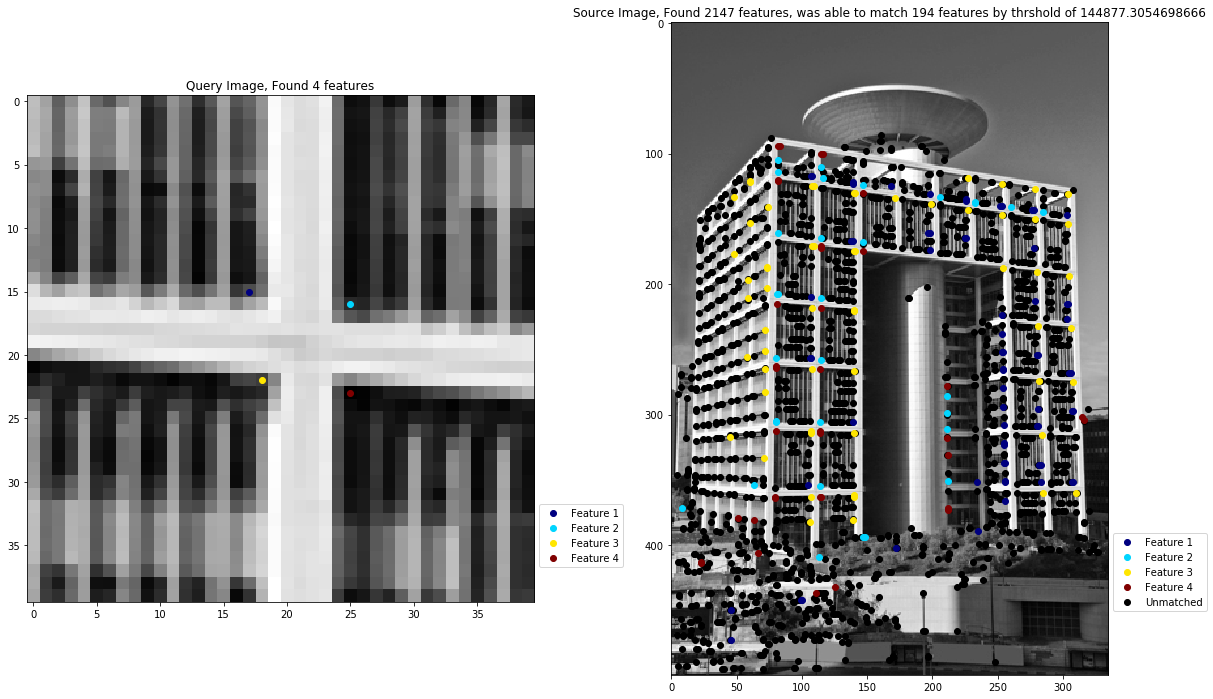

In [31]:
display_result(descSIFTSource,descSIFTQuery,9,'SIFT')
#remove comment to display without match to each feature 
#display_not_detailed_result(descSIFTSource,descSIFTQuery,10,'SIFT')

# Good luck !